In [31]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from model import Model
%matplotlib inline

device = "cuda"
torch.set_grad_enabled(False)
torch.set_default_device(device)
         
# boundary conditions used in training data
BC_0 = { "mode": "circular", "val_left": None, "val_right": None }
BC_1 = { "mode": "circular", "val_left": None, "val_right": None }

normalize = lambda x: (x+20)/40
denormalize = lambda x: x*40-20

dt = 0.01
L = 60*np.pi

# err = (model(X) - D[k,None,:,:])[0,:,:].abs().cpu()
# prev_frame_error = (X - D[k,None,:,:])[0,:,:].abs().cpu()
# 
# fig, ax = plt.subplots(1,3,figsize=(15,3))
# plt.colorbar(ax[0].matshow(err))
# plt.colorbar(ax[1].matshow(prev_frame_error))
# ax[2].hist(prev_frame_error.flatten(),label="prev frame error")
# ax[2].hist(err.flatten(), label="model error")
# ax[2].legend()
# plt.show()

In [70]:
# trains model for the 2d case
D = torch.tensor(np.load("../ks2d/ks2d_short.npy"))
D = normalize(D)

X, Y = D[0,None,...], D[1,None,...]
X_noisy = X + torch.distributions.Normal(0, 1e-5).sample(X.shape) 
Y_noisy = Y

model = Model(bc=[BC_0, BC_1])
model.train(X_noisy, Y_noisy)

In [78]:
D = torch.tensor(np.load("ks1d_dimensionless.npy"))
D = normalize(D)

# This is really important. 
# I don't know why, but shenfun doesn't simulate the "true" KS equation in 2d but a version that keeps its mean at zero. 
# The 1d version I have simulated doesn't do that; its average value diverges.
# The following line takes the average value back to zero.
D = D - D.mean(dim=1)[:,None] 

X, Y = D[-2,None,:], D[-1,None,:]
X_noisy = X + torch.distributions.Normal(0, 1e-5).sample(X.shape) 
Y_noisy = Y

model = Model(bc=[BC_0, BC_1])
model.train(X_noisy, Y_noisy)

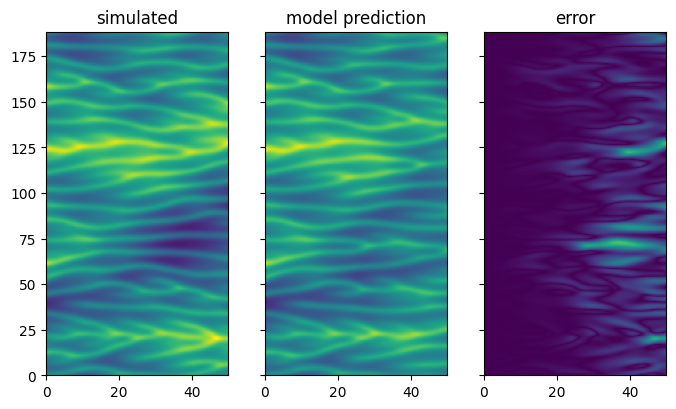

In [76]:
# plots results for the 1d case
D = torch.tensor(np.load("ks1d_dimensionless.npy"))
D = normalize(D)
D = D - D.mean(dim=1)[:,None] 

# simulates the model for a few time steps and compares it to shenfuns prediction
N0 = 5000
T = dt * (D.shape[0] - N0)
d_new = torch.empty(D.shape[0]-N0,D.shape[1]).double()
d_new[0,:] =  D[N0,:]
for i in range(D.shape[0]-N0-1):
    d_new[i+1,:] = model(d_new[i,None,:])[0,:]

# plots
fig, ax = plt.subplots(1,3,figsize=(8,5),sharey=True)
ax[0].imshow(D[N0:].T.cpu(), extent=[0,T,0,L], vmin=-0.3, vmax=0.3, aspect=1/2)
ax[0].set_title("simulated")
ax[1].imshow(d_new.T.cpu(), extent=[0,T,0,L], vmin=-0.3, vmax=0.3, aspect=1/2)
ax[1].set_title("model prediction")
ax[2].imshow((D[N0:]-d_new).abs().T.cpu(), extent=[0,T,0,L], vmin=0, vmax=0.5, aspect=1/2)
ax[2].set_title("error")
plt.show()

Text(0, 0.5, 'error')

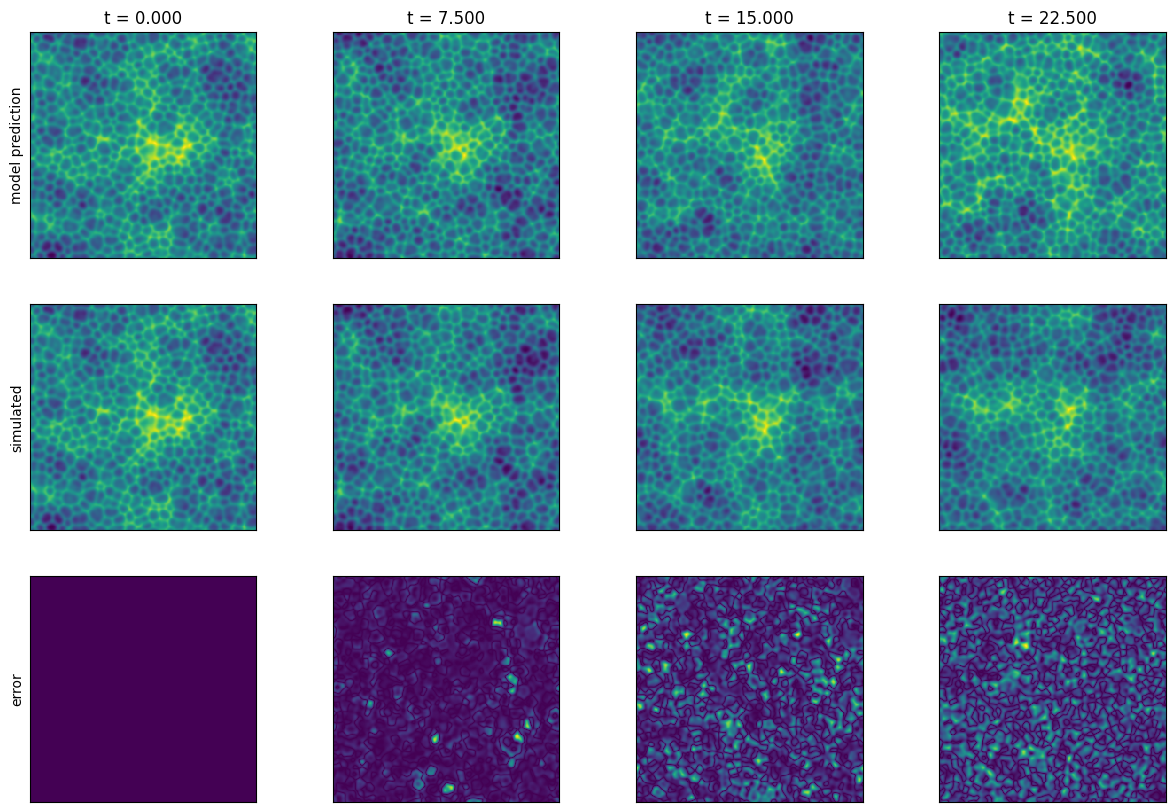

In [79]:
# plots results for the 2d case
D = torch.tensor(np.load("../ks2d/ks2d_long.npy"))
D = normalize(D)

T = 0.5 * D.shape[0]
d_new = torch.empty(D.shape[0],*D.shape[1:]).double()
d_new[0,...] = D[0,...]
x = d_new[0,None,...]
for i in range(D.shape[0]-1):
    print(i,end="\r")
    for t in range(50):
        x = model(x)
    d_new[i+1,...] = x[0,...]

fig, ax = plt.subplots(3,4,figsize=(15,10))
for i in range(4):
    k = int( D.shape[0]*(i/4) )
    ax[0][i].matshow(d_new[k,...].cpu().numpy())
    ax[1][i].matshow(D[k,...].cpu().numpy())
    error = ( d_new[k,...] - D[k,...] ).abs()
    ax[2][i].matshow(error.cpu().numpy())
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    ax[2][i].set_xticks([])
    ax[2][i].set_yticks([])
    ax[0][i].set_title(f"t = {T*i/4:.3f}")
ax[0][0].set_ylabel("model prediction")
ax[1][0].set_ylabel("simulated")
ax[2][0].set_ylabel("error")

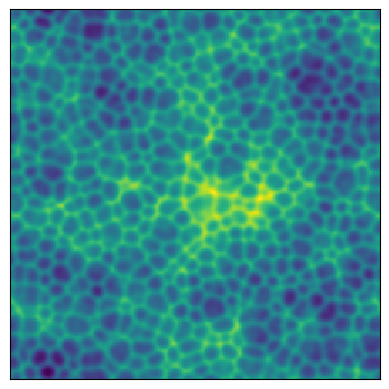

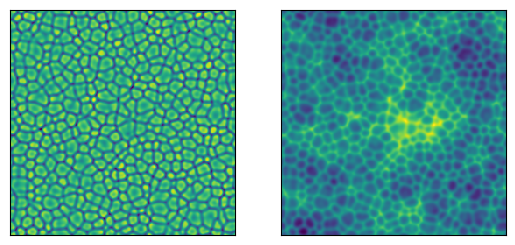

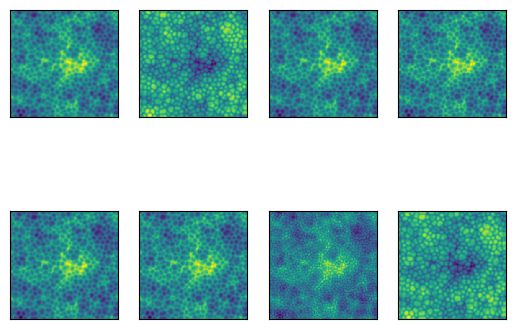

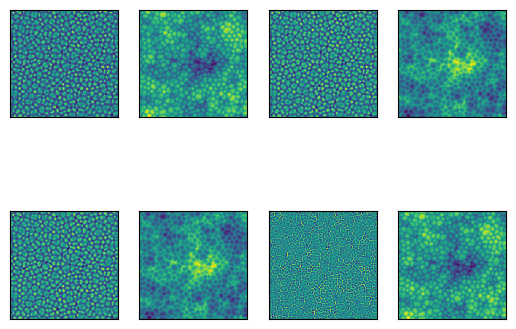

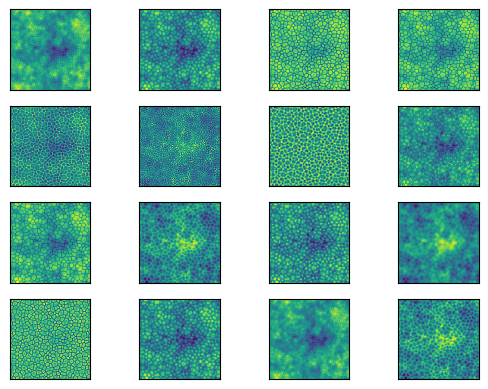

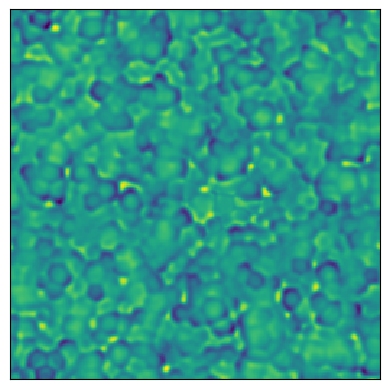

In [57]:
%matplotlib inline
# %matplotlib qt

def plot_scalar_fields(field):
    lenx = int((field.shape[1])**0.5)
    leny = int( field.shape[1]/ lenx + 0.5)
    _, ax = plt.subplots(lenx, leny, squeeze=False)
    for i in range(lenx):
        for j in range(leny):
            ax[i][j].matshow( field[0,i*lenx+j,:,:].cpu().numpy() )
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
    plt.show()

X_tmp = X - X.mean(dim=[1,2])
X_tmp = model.pad(X_tmp)
X_tmp = X_tmp.unsqueeze(1)
plot_scalar_fields(X_tmp)
X_tmp = X_tmp.repeat(1, 2, *[1]*len(X_tmp.shape[2:]))
X_tmp = model.block1[0](X_tmp)
plot_scalar_fields(X_tmp)
X_tmp = model.block1[1](X_tmp)
X_tmp = model.block1[2](X_tmp)
plot_scalar_fields(X_tmp)
X_tmp = model.block2[0](X_tmp)
plot_scalar_fields(X_tmp)
X_tmp = model.block2[1](X_tmp)
X_tmp = model.block2[2](X_tmp)
plot_scalar_fields(X_tmp)
X_tmp = model.lin_out(X_tmp)
plot_scalar_fields(X_tmp)


0.0
0.00014367551148952717
0.000262168417730857
0.00037500669594892067
0.0004811395639963134
0.0005792536816943139
0.0006702847469618467
0.0007550365370340151
0.000834180081531688
0.0009082716864782236


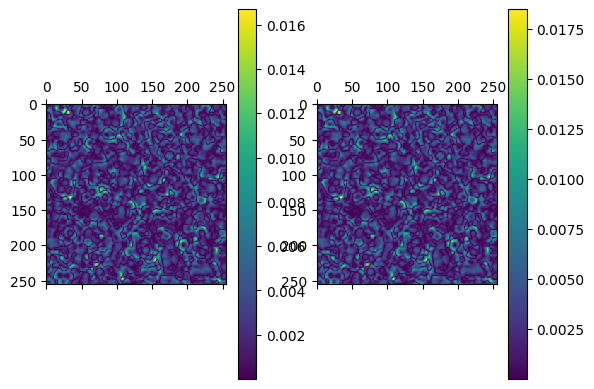

In [2]:
Xs = [ X ]
# n_plots = D.shape[0]
# fig, ax = plt.subplots(3,n_plots,figsize=(20,6))
for i in range(D.shape[0]): 
    # ax[0][i].matshow(Xs[i][0,:,:].cpu(),vmax=1,vmin=0)
    # ax[1][i].matshow(D[i,:,:].cpu(),vmax=1,vmin=0)
    err = (D[i,:,:] - Xs[i][0,:,:]).abs().cpu()
    # ax[2][i].matshow(err)
    print(err.max().item())
    Xs.append(model(Xs[i]))
# plt.show()

fig, ax = plt.subplots(1,2)
plt.colorbar(ax[0].matshow( (D[0,...]-D[-1,...]).abs().cpu() ))
plt.colorbar(ax[1].matshow( (Xs[0][0,...]-Xs[-1][0,...]).abs().cpu() ))
plt.show()

In [14]:
# enjoy a nice animation
import itertools
import copy
%matplotlib qt
torch.set_grad_enabled(False)

# Dirichlet boundary conditions
# BC_0 = { "mode": "dirichlet", "val_left": 0, "val_right": 0 } # vertical axis
# BC_1 = { "mode": "dirichlet", "val_left": 0, "val_right": 0 } # horizontal axis
# model.bc = [BC_0, BC_1]
# 
# # fit initial condition to the boundary conditions, i.e., smoothly transition
# # boundary values to 0
# T = X
# z = torch.sin(torch.linspace(0,torch.pi,X.shape[2])).expand_as(T)
# z = z * torch.sin(torch.linspace(0,torch.pi,X.shape[2])).expand_as(T).transpose(2,3)
# T = T * z
T = X

im = plt.matshow(T[0,...].cpu().numpy(), vmin=0, vmax=1)
model_fast = copy.deepcopy(model) 
model_fast.to(torch.float32)
T_fast = T.to(torch.float32)
energy = T_fast.mean()
for j in itertools.count():
    # T_fast = T_fast + model_fast(T_fast - T_fast.mean(dim=[1,2]))
    T_fast = model_fast(T_fast)
    # time.sleep(.1)
    # T_fast = energy + T_fast - T_fast.mean() # normalizes energy level
    if j % 20 == 0:
        im.set_data(T_fast[0,...].cpu().numpy())
        plt.pause(0.000001)
        plt.draw()
        # print("x")
        # input()

KeyboardInterrupt: 

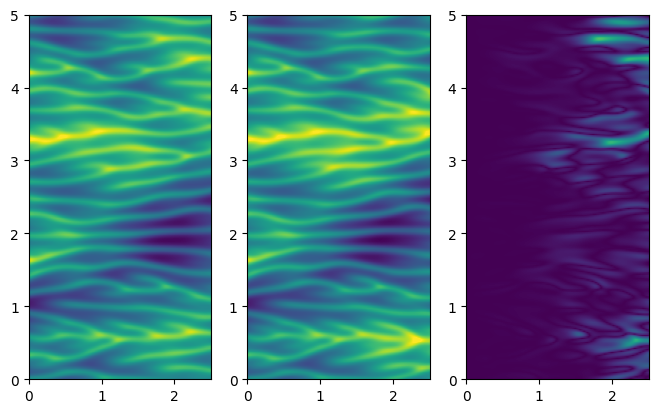

In [14]:
import numpy as np
%matplotlib inline
D = torch.tensor(np.load("ks1d_dimensionless.npy"))
D = normalize(D)

# This is really important. 
# I don't know why, but shenfun doesn't simulate the "true" KS equation in 2d but a version that keeps its mean at zero. 
# The 1d version I have simulated doesn't do that; its average value diverges.
# The following line takes the average value back to zero.
D = D - D.mean(dim=1)[:,None] 

D = D[-2:,:]
X, Y = D[0,None,:], D[1,None,:]
model = Model(bc=[BC_0, BC_1])
model.train(X, Y)

# plt.colorbar ( plt.imshow( d.T.cpu(), extent=[0,10,0,10]) )
# plt.show()
# 
# X, Y = d[8000,None,:], d[8001,None,:]
# 
# plt.plot( (f(X) - Y).flatten().cpu(), label="f(X) - Y" )
# # plt.plot( ( X + model(X) - Y ).flatten().cpu(), label="f(X)" )
# plt.plot(   (X - Y).flatten().cpu(), label="X - Y" )
# plt.legend()

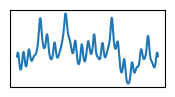

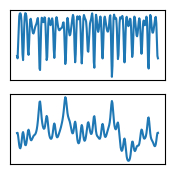

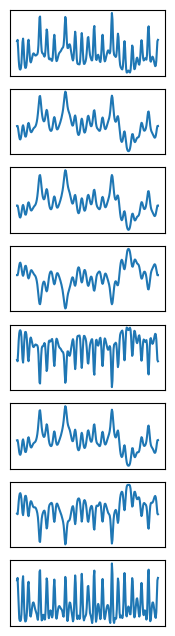

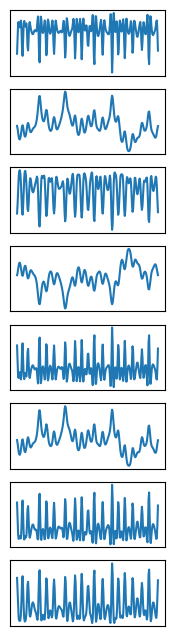

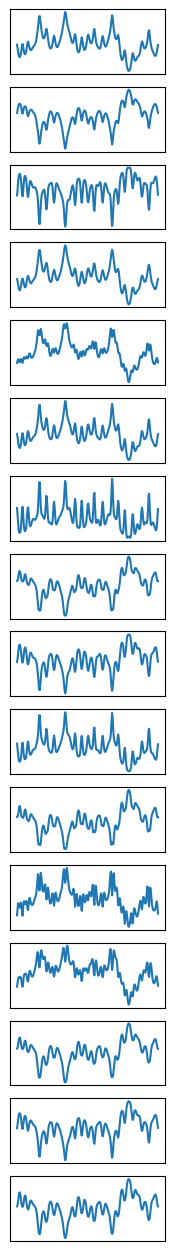

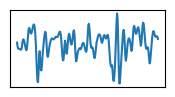

In [76]:
%matplotlib inline
# %matplotlib qt

def plot_scalar_fields(field):
    # lenx = int((field.shape[1])**0.5)
    # leny = int( field.shape[1]/ lenx + 0.5)
    leny = field.shape[1]
    lenx = 1
    _, ax = plt.subplots(leny, lenx, figsize=(2,leny),squeeze=False)
    for i in range(lenx):
        for j in range(leny):
            ax[j][i].plot( field[0,i*lenx+j,:].cpu().numpy() )
            ax[j][i].set_xticks([])
            ax[j][i].set_yticks([])
    plt.show()

X = d_new[0,None,:]
X_tmp = X - X.mean(dim=1)
X_tmp = model.pad(X_tmp)
X_tmp = X_tmp.unsqueeze(1)
plot_scalar_fields(X_tmp)
X_tmp = X_tmp.repeat(1, 2, *[1]*len(X_tmp.shape[2:]))
X_tmp = model.block1[0](X_tmp)
plot_scalar_fields(X_tmp)
X_tmp = model.block1[1](X_tmp)
X_tmp = model.block1[2](X_tmp)
plot_scalar_fields(X_tmp)
X_tmp = model.block2[0](X_tmp)
plot_scalar_fields(X_tmp)
X_tmp = model.block2[1](X_tmp)
X_tmp = model.block2[2](X_tmp)
plot_scalar_fields(X_tmp)
X_tmp = model.lin_out(X_tmp)
plot_scalar_fields(X_tmp)


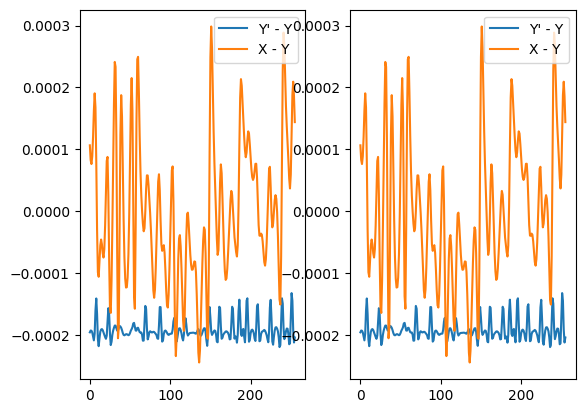

In [441]:
h = 60 * np.pi / 256
dt = 0.01
extent = 1

fig, ax = plt.subplots(1,2)

# completely one-dimensional
X_ = torch.cat((X[:,-2*extent:],X,X[:,:2*extent]),dim=1).unsqueeze(1)
X_ = denormalize(X_)
lap = torch.tensor([1,-2,1]).double().view(1,1,3) / h**2
id = torch.tensor([0,1,0]).double().view(1,1,3)
conv = torch.nn.functional.conv1d
dX_ = - conv(conv(X_,lap),lap) - conv(conv(X_,lap),id) - 0.5 * ( 0.5 * conv(conv(X_**2,lap),id) - conv(conv(X_,id)*conv(X_,lap),id))
Y_ = denormalize(X) + dt * dX_
Y_ = Y_[:,0,:]
Y_ = normalize(Y_)
ax[0].plot(  (Y_ - Y).flatten().cpu(), label="Y' - Y" )
ax[0].plot(  (X - Y).flatten().cpu(), label="X - Y" )
ax[0].legend()

# two-dimensional
X_ = X_.unsqueeze(3).repeat(1,1,1,2*2*extent+1)
lap = torch.tensor([[1,2,1],[2,-12,2],[1,2,1]]).double().view(1,1,3,3) / h**2 / 4
id = torch.tensor([[0,0,0],[0,1,0],[0,0,0]]).double().view(1,1,3,3)
conv = torch.nn.functional.conv2d
dX_ = - conv(conv(X_,lap),lap) - conv(conv(X_,lap),id) - 0.5 * ( 0.5 * conv(conv(X_**2,lap),id) - conv(conv(X_,id)*conv(X_,lap),id))
dX_ = dX_[:,0,:,0]
Y_ = denormalize(X) + dt * dX_
Y_ = normalize(Y_)
 
ax[1].plot(  (Y_ - Y).flatten().cpu(), label="Y' - Y" )
ax[1].plot(  (X - Y).flatten().cpu(), label="X - Y" )
ax[1].legend()

plt.show()

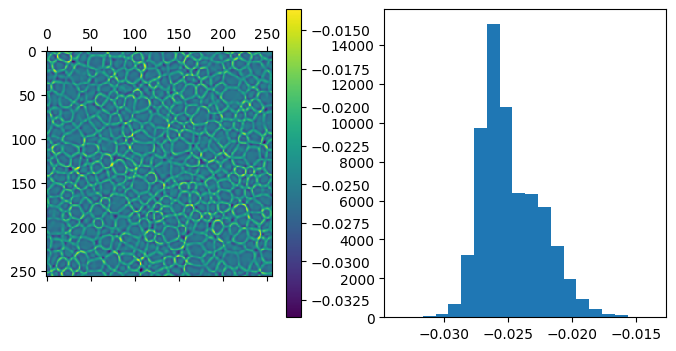

In [426]:

# this is very interesting: the finite-difference method comes with a *constant* bias 
# to the solution computed by shenfun ... which one is correct ?


D = torch.tensor(np.load("../ks2d/ks2d_short.npy"))
X, Y = D[0,None,None,...], D[1,None,None,...]

# two-dimensional
X_ = pad(pad(X, 2, 2), 3, 2)
lap = torch.tensor([[1,2,1],[2,-12,2],[1,2,1]]).double().view(1,1,3,3) / h**2 / 4
id = torch.tensor([[0,0,0],[0,1,0],[0,0,0]]).double().view(1,1,3,3)
conv = torch.nn.functional.conv2d
dX_ = - conv(conv(X_,lap),lap) - conv(conv(X_,lap),id) - 0.5 * ( 0.5 * conv(conv(X_**2,lap),id) - conv(conv(X_,id)*conv(X_,lap),id))
Y_ = X + dt * dX_

fig, ax = plt.subplots(1,2,figsize=(8,4))
plt.colorbar( ax[0].matshow((Y_-Y)[0,0,...].cpu().numpy()) )
ax[1].hist( (Y_-Y).flatten().cpu().numpy(), bins=20 )
plt.show()